In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
stemmer= PorterStemmer()
lemmatizer = WordNetLemmatizer()
from gensim.models import FastText
from gensim.models import doc2vec
from gensim.models import Doc2Vec

C:\Users\gokul\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
company ='APPLE'
time = '240'
# file =  "Labeled_news/"+ company +'_'+  str(time) + "_labeled_news.csv"
file = "D:\SWM Project\Labeled_news\Labeled_news\\" + company +'_'+  str(time) + "_labeled_news.csv"

In [3]:
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument

In [4]:
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

In [5]:
df = pd.read_csv(file)
df = df.drop(df[df['Positive_Sentiment'].isnull()].index)
df['Text'] = df['Text'].str.lower()
df_strip = df[['Text','Positive_Sentiment']]
import re
import seaborn as sns
import matplotlib.pyplot as plt
cnt_pro = df_strip['Positive_Sentiment'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

<Figure size 1200x400 with 1 Axes>

In [6]:
df_strip.shape

(13104, 2)

In [7]:
df_strip.index = range(df_strip.shape[0])
df_strip['Text'].apply(lambda x: len(x.split(' '))).sum()

6781916

# Data cleaning

In [8]:
train, test = train_test_split(df_strip, test_size=0.3, random_state=42)

import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

def cleaning(text):
    text = re.sub(r'\d+','', text)
    text = text.translate(str.maketrans('','',string.punctuation))
    text = text.strip()
    tokens = word_tokenize(text)
    text_array = [i for i in tokens if not i in ENGLISH_STOP_WORDS]
    result =[]
    for text in text_array:
        result.append(lemmatizer.lemmatize(text))
    return result

train_tagged = train.apply(
    lambda r: TaggedDocument(words=cleaning(r['Text']), tags=[r.Positive_Sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=cleaning(r['Text']), tags=[r.Positive_Sentiment]), axis=1)

# Building vocabulary

In [9]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|█████████████████████████████████████████████████████████████████████████| 9172/9172 [00:00<00:00, 3066328.41it/s]


In [10]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|█████████████████████████████████████████████████████████████████████████| 9172/9172 [00:00<00:00, 4561318.03it/s]


In [11]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|█████████████████████████████████████████████████████████████████████████| 9172/9172 [00:00<00:00, 3065351.10it/s]


Wall time: 35.2 s


In [12]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [13]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

## Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegressionCV
x_train_scaled = min_max_scaler.fit_transform(X_train)
x_test_scaled = min_max_scaler.fit_transform(X_test)

logreg = LogisticRegression()
clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='warn', max_iter=100, multi_class='warn', verbose=0, warm_start=False, n_jobs=None).fit(X_train,y_train)
y_train_pred= clf.predict(X_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

print('Training accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Testing F1 score: {}'.format(f1_score(y_train, y_train_pred, average='weighted')))
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

C:\Users\gokul\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training accuracy 0.7896860008722199
Testing F1 score: 0.7896758101518356
Testing accuracy 0.6187690742624619
Testing F1 score: 0.6185655007626841


<Figure size 432x288 with 0 Axes>

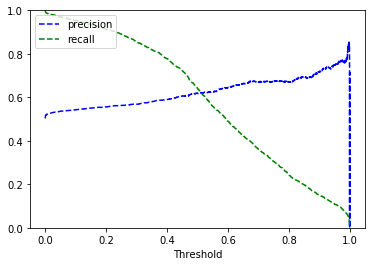

<Figure size 432x288 with 0 Axes>

In [15]:
from sklearn.metrics import precision_recall_curve
pre, rec, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
plot_prec_recall_vs_tresh(pre, rec, thresholds)
plt.figure()

## Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0, n_estimators=100,class_weight='balanced')
clf.fit(X_train,y_train)
y_train_pred= clf.predict(X_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

print('Training accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Testing F1 score: {}'.format(f1_score(y_train, y_train_pred, average='weighted')))
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Training accuracy 1.0
Testing F1 score: 1.0
Testing accuracy 0.6279247202441506
Testing F1 score: 0.6274133821949751


<Figure size 432x288 with 0 Axes>

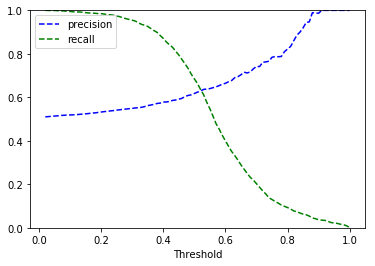

<Figure size 432x288 with 0 Axes>

In [17]:
from sklearn.metrics import precision_recall_curve
pre, rec, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
plot_prec_recall_vs_tresh(pre, rec, thresholds)
plt.figure()

## SVM

In [18]:
from sklearn import svm
clf = svm.SVC(gamma='scale',probability=True)
clf.fit(X_train, y_train) 
clf.score(X_test,y_test)

0.6195320447609359

<Figure size 432x288 with 0 Axes>

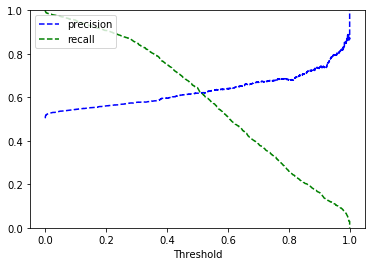

<Figure size 432x288 with 0 Axes>

In [19]:
from sklearn.metrics import precision_recall_curve
pre, rec, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
plot_prec_recall_vs_tresh(pre, rec, thresholds)
plt.figure()

In [20]:
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing F1 score: 0.6274133821949751


In [21]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|█████████████████████████████████████████████████████████████████████████| 9172/9172 [00:00<00:00, 2095895.19it/s]


In [22]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|█████████████████████████████████████████████████████████████████████████| 9172/9172 [00:00<00:00, 1804670.28it/s]


Wall time: 2min 25s


# Distributed Memory(DM)

In [23]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

## Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegressionCV
x_train_scaled = min_max_scaler.fit_transform(X_train)
x_test_scaled = min_max_scaler.fit_transform(X_test)

logreg = LogisticRegression()
clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='warn', max_iter=100, multi_class='warn', verbose=0, warm_start=False, n_jobs=None).fit(X_train,y_train)
y_train_pred= clf.predict(X_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

print('Training accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Testing F1 score: {}'.format(f1_score(y_train, y_train_pred, average='weighted')))
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

C:\Users\gokul\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training accuracy 0.6289795028347144
Testing F1 score: 0.6288903465890184
Testing accuracy 0.5254323499491353
Testing F1 score: 0.5254205612180429


<Figure size 432x288 with 0 Axes>

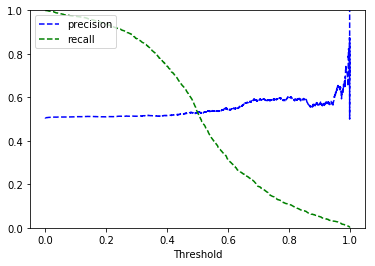

<Figure size 432x288 with 0 Axes>

In [25]:
from sklearn.metrics import precision_recall_curve
pre, rec, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
plot_prec_recall_vs_tresh(pre, rec, thresholds)
plt.figure()

## Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0, n_estimators=100,class_weight='balanced')
clf.fit(X_train,y_train)
y_train_pred= clf.predict(X_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

print('Training accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Testing F1 score: {}'.format(f1_score(y_train, y_train_pred, average='weighted')))
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Training accuracy 1.0
Testing F1 score: 1.0
Testing accuracy 0.5058494404883012
Testing F1 score: 0.5050728232211091


<Figure size 432x288 with 0 Axes>

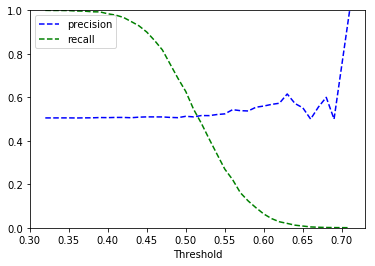

<Figure size 432x288 with 0 Axes>

In [27]:
from sklearn.metrics import precision_recall_curve
pre, rec, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
plot_prec_recall_vs_tresh(pre, rec, thresholds)
plt.figure()

## SVM

In [28]:
from sklearn import svm
clf = svm.SVC(gamma='scale',probability=True)
clf.fit(X_train, y_train) 
clf.score(X_test,y_test)

0.5142421159715158

<Figure size 432x288 with 0 Axes>

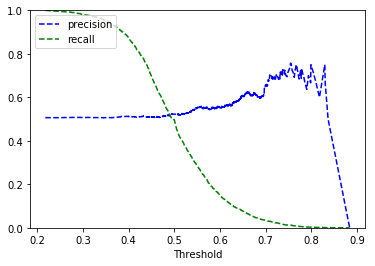

<Figure size 432x288 with 0 Axes>

In [29]:
from sklearn.metrics import precision_recall_curve
pre, rec, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
plot_prec_recall_vs_tresh(pre, rec, thresholds)
plt.figure()